In [1]:
from IPython.display import Image
import itertools

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab

import autograd.numpy as np
from autograd import grad

%matplotlib inline

Let's define a function to perform [AdaM](https://arxiv.org/abs/1412.6980) updates...

In [2]:
# AdaM: Adaptive Moments Optimizer
## Params
### alpha0: base learning rate
### grad: current gradient
### adam_values: dictionary containing moment estimates

def get_AdaM_update(alpha_0, grad, adam_values, b1=.95, b2=.999, e=1e-8):
    adam_values['t'] += 1

    # update mean                                                                                                                                                                                                     
    adam_values['mean'] = b1 * adam_values['mean'] + (1-b1) * grad
    m_hat = adam_values['mean'] / (1-b1**adam_values['t'])

    # update variance                                                                                                                                                                                                 
    adam_values['var'] = b2 * adam_values['var'] + (1-b2) * grad**2
    v_hat = adam_values['var'] / (1-b2**adam_values['t'])

    return alpha_0 * m_hat/(np.sqrt(v_hat) + e)

## 1.  [Perturbative Black Box VI](https://arxiv.org/abs/1709.07433)

Consider the quantity $$ V(\boldsymbol{\theta}; \boldsymbol{\phi}) = -\log p(\mathbf{X}, \boldsymbol{\theta}) + \log q(\boldsymbol{\theta}; \boldsymbol{\phi}),$$ which is just the negative of the [*Evidence Lower Bound* (ELBO)](http://www.umiacs.umd.edu/~xyang35/files/understanding-variational-lower.pdf) without the enclosing expectation (i.e. ELBO $= \mathbb{E}_{q}[- V(\boldsymbol{\theta}; \boldsymbol{\phi})]$).  Perturbative black box variational inference (PBBVI) considers the quantity: $$ p(\mathbf{X}) = \mathbb{E}_{q(\boldsymbol{\theta}; \boldsymbol{\phi})}[ f(e^{- V(\boldsymbol{\theta}; \boldsymbol{\phi})})].$$  When $f$ is the identity function, the objective becomes [an importance weighted estimate of evidence](https://arxiv.org/abs/1509.00519), and when $f$ is $\log$, then the ELBO is recovered.  Things get interesting when we consider functions between the aforementioned two.  Bamler et al. propose using an odd-ordered Taylor expansion around some point $V_{0}$.  For order three, we have: $$ p(\mathbf{X}) \ge e^{-V_{0}} \mathbb{E}_{q(\boldsymbol{\theta}; \boldsymbol{\phi})}[ 1 + (V_{0} - V(\boldsymbol{\theta}; \boldsymbol{\phi})) + \frac{1}{2} (V_{0} - V(\boldsymbol{\theta}; \boldsymbol{\phi}))^{2} + \frac{1}{6} (V_{0} - V(\boldsymbol{\theta}; \boldsymbol{\phi}))^{3} ].$$  $V(\boldsymbol{\theta}; \boldsymbol{\phi})$ enters the equation polynomially, not exponentially, and thus a Monte Carlo estimate of the objective has lower variance than the importance sampled direct estimate (i.e. $f$ is the identity).  Moreover, the bound is tighter than the ELBO, thus giving the best of both objectives.   

## 2.  Experiment: Mixture Density

We are going to demonstrate all techniques on a simulated posterior.  As posteriors in the wild are often multimodal, we'll use a Gaussian mixture as our demonstration...

In [3]:
# Gaussian
def gaussPdf(x, params):
    # params: {'mu': mean, 'sigma': standard dev.}
    return (1./np.sqrt(2*np.pi*params['sigma']**2)) * np.exp((-.5/params['sigma']**2) * np.sum((x-params['mu'])**2))

# 2D Gaussian Mixture
def logGaussMixPDF(x, params):
    # params: {'pi': list of weights, 'mu': list of means, 'sigma': list of standard devs}
    return np.log(params['pi'][0] * gaussPdf(x, {'mu':params['mu'][0], 'sigma':params['sigma'][0]}) \
            + params['pi'][1] * gaussPdf(x, {'mu':params['mu'][1], 'sigma':params['sigma'][1]}))

Let's choose the parameters and plot the density...

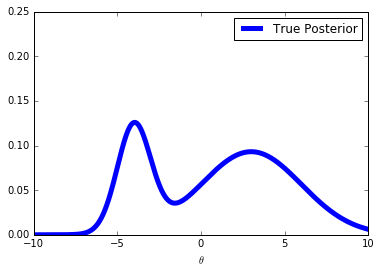

In [4]:
true_posterior_params = {
    'mu': [-4,3],
    'sigma': [1, 3],
    'pi': [.3, .7]
}

plt.figure()

theta_grid = np.linspace(-10, 10, 1000)

probs_true = [np.exp(logGaussMixPDF(z, true_posterior_params)) for z in theta_grid]
plt.plot(theta_grid, probs_true, 'b-', linewidth=5, label="True Posterior")

plt.xlabel(r"$\theta$")
plt.xlim([-10,10])
plt.ylim([0,.25])
plt.legend()

plt.show()

###  Variational Inference via ELBO

Now let's fit a Gaussian approximation--$q(\boldsymbol{\theta};\boldsymbol{\phi}) \ = \ \text{N}(\boldsymbol{\mu}_{\boldsymbol{\phi}}, \boldsymbol{\sigma}_{\boldsymbol{\phi}})$--via the ELBO...

In [5]:
# Entropy of Gaussian
def gaussEntropy(log_sigma):
    return .5 * np.mean(np.log(2*np.pi*np.e) + 2.*log_sigma)

# Function for sampling from Gaussian location-scale form
def sample_from_Gauss(mu, log_sigma):
    e = np.random.normal()
    return mu + np.exp(log_sigma) * e, e


### GET DERIVATIVES ###

# d log p(X, \theta) / d \theta
logModel = logGaussMixPDF
dLogModel_dTheta = grad(logModel)

# d theta / d log_sigma
### we'll implement this ourselves

# d entropy / d log_sigma
dEntropy_dLogSigma = grad(gaussEntropy)

Now lets initialize the variational parameters and optimize the ELBO...

In [6]:
### INIT VARIATIONAL PARAMS 
phi = {'mu':-5., 'log_sigma':0.}


### ELBO OPTIMIZATION
maxEpochs = 750
learning_rate = .1
adam_values = {'mu':{'mean': 0., 'var': 0., 't': 0}, 'log_sigma':{'mean': 0., 'var': 0., 't': 0}}
n_samples = 10

for epochIdx in range(maxEpochs):
    
    elbo_grad_mu, elbo_grad_log_sigma = 0., 0.
    for s in range(n_samples):
        
        theta_hat, rand_seed = sample_from_Gauss(phi['mu'], phi['log_sigma'])
        dModel_dTheta = dLogModel_dTheta(theta_hat, true_posterior_params)
        
        elbo_grad_mu += 1./n_samples * dModel_dTheta * 1.
        elbo_grad_log_sigma += 1./n_samples * dModel_dTheta * rand_seed * np.exp(phi['log_sigma'])
        
    elbo_grad_log_sigma += dEntropy_dLogSigma(phi['log_sigma'])
        
    phi['mu'] += get_AdaM_update(learning_rate, elbo_grad_mu, adam_values['mu'])  
    phi['log_sigma'] += get_AdaM_update(learning_rate, elbo_grad_log_sigma, adam_values['log_sigma']) 
        
print phi

{'mu': 1.4819512849313834, 'log_sigma': 1.203520807137715}


Let's visualize the results...

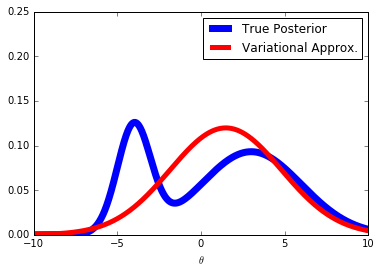

In [7]:
probs_elbo_approx = [gaussPdf(z, {'mu':phi['mu'], 'sigma':np.exp(phi['log_sigma'])}) for z in theta_grid] 
    
plt.figure()

plt.plot(theta_grid, probs_true, 'b-', linewidth=7, label="True Posterior")
plt.plot(theta_grid, probs_elbo_approx, '-r', linewidth=5, label="Variational Approx.")

plt.xlabel(r"$\theta$")
plt.xlim([-10,10])
plt.ylim([0,.25])
plt.legend()

plt.show()

###  Variational Inference via PBBVI

Let's fit the Normal approximation again but with PBBVI this time.  We assume $V_{0}=0$, as done for the paper's similar experiment...

In [8]:
### INIT VARIATIONAL PARAMS 
phi = {'mu':-5., 'log_sigma':0.}


### ELBO OPTIMIZATION
maxEpochs = 750
learning_rate = .1
adam_values = {'mu':{'mean': 0., 'var': 0., 't': 0}, 'log_sigma':{'mean': 0., 'var': 0., 't': 0}}
n_samples = 10

for epochIdx in range(maxEpochs):
    
    elbo_val, elbo_grad_mu, elbo_grad_log_sigma = 0., 0., 0.
    for s in range(n_samples):
        
        theta_hat, rand_seed = sample_from_Gauss(phi['mu'], phi['log_sigma'])
        dModel_dTheta = dLogModel_dTheta(theta_hat, true_posterior_params)
        elbo_val += 1./n_samples * logModel(theta_hat, true_posterior_params)
        
        elbo_grad_mu += 1./n_samples * dModel_dTheta * 1.
        elbo_grad_log_sigma += 1./n_samples * dModel_dTheta * rand_seed * np.exp(phi['log_sigma'])
        
    elbo_grad_log_sigma += dEntropy_dLogSigma(phi['log_sigma'])
    elbo_val += gaussEntropy(phi['log_sigma'])
    
    ppvi_grad_mu = elbo_grad_mu + elbo_val * elbo_grad_mu + .5 * elbo_val**2 * elbo_grad_mu
    ppvi_grad_log_sigma = elbo_grad_log_sigma + elbo_val * elbo_grad_log_sigma + .5 * elbo_val**2 * elbo_grad_log_sigma
        
    phi['mu'] += get_AdaM_update(learning_rate, ppvi_grad_mu, adam_values['mu'])  
    phi['log_sigma'] += get_AdaM_update(learning_rate, ppvi_grad_log_sigma, adam_values['log_sigma']) 
        
print phi

{'mu': 1.2800101740121075, 'log_sigma': 1.3681604324867422}


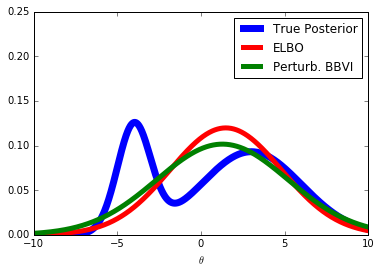

In [9]:
probs_pbbvi_approx = [gaussPdf(z, {'mu':phi['mu'], 'sigma':np.exp(phi['log_sigma'])}) for z in theta_grid] 
    
plt.figure()

plt.plot(theta_grid, probs_true, 'b-', linewidth=7, label="True Posterior")
plt.plot(theta_grid, probs_elbo_approx, '-r', linewidth=5, label="ELBO")
plt.plot(theta_grid, probs_pbbvi_approx, '-g', linewidth=5, label="Perturb. BBVI")

plt.xlabel(r"$\theta$")
plt.xlim([-10,10])
plt.ylim([0,.25])
plt.legend()

plt.show()

We see that, indeed, PBBVI found a more dispersed approximation.

## 3.  Experiment: Regression

Next we'll examine the model uncertainty in a regression setting.

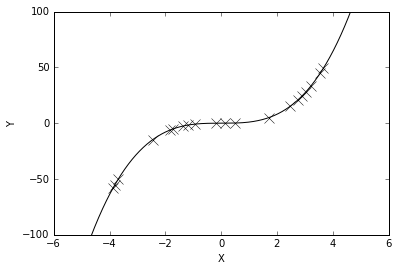

In [160]:
# Simulate data
N = 20
x = np.array([np.random.uniform(-4,4) for n in range(N)])[np.newaxis].T
y = x**3

# True function
x_true = np.linspace(start=-6, stop=6, num=1000)
y_true = x_true**3

plt.plot(x_true, y_true, 'k-')
plt.plot(x, y, 'xk', ms=10, linewidth=1)

plt.xlabel("X")
plt.ylabel("Y")
plt.xlim([-6, 6])
plt.ylim([-100, 100])
plt.legend(loc=2)
plt.show()

In [161]:
# Regression Neural Network
def logModel(W, b, x, y):
    h = np.maximum(np.dot(x, W[:, :50]) + b[:, :50], 0.)
    y_hat = np.dot(h, W[:, 50:].T) + b[:, 50:]
    return np.sum( .5 * (y - y_hat)**2 )

def fprop(W, b, x):
    h = np.maximum(np.dot(x, W[:, :50]) + b[:, :50], 0.)
    return np.dot(h, W[:, 50:].T) + b[:, 50:]

# Gauss-to-Gauss KLD
def gaussKLD(mu, log_sigma, prior_mu=0., prior_sigma=.0001):
    kl = -np.log(prior_sigma**2)
    kl += -(np.exp(2*log_sigma) + (mu - prior_mu)**2)/(prior_sigma**2)
    kl += 2*log_sigma + 1.
    return -0.5*kl.mean()


### GET DERIVATIVES ###

# d log p(X, \theta) / d \theta
dLogModel_dW = grad(logModel)
dLogModel_db = grad(lambda b, W, x, y: logModel(W, b, x, y))

# d entropy / d log_sigma
dKLD_dmu = grad(gaussKLD)
dKLD_dLogSigma = grad(lambda p1, p2: gaussKLD(p2, p1))

###  Variational Inference via ELBO

Now let's fit a Gaussian approximation--$q(\boldsymbol{\theta};\boldsymbol{\phi}) \ = \ \text{N}(\boldsymbol{\mu}_{\boldsymbol{\phi}}, \boldsymbol{\sigma}_{\boldsymbol{\phi}})$--via the ELBO...

In [162]:
### INIT VARIATIONAL PARAMS 
phi = {'mu': .001 * np.random.normal(size=(1,100)), 'log_sigma': .0001*np.ones((1,100)), 'b': np.zeros((1,51))}


### ELBO OPTIMIZATION
maxEpochs = 200
learning_rate = .01
adam_values = {'mu':{'mean': 0., 'var': 0., 't': 0}, 
               'log_sigma':{'mean': 0., 'var': 0., 't': 0}, 
               'b':{'mean': 0., 'var': 0., 't': 0}}

n_samples = 50
for epochIdx in range(maxEpochs):
    
    elbo_val, elbo_grad_mu, elbo_grad_log_sigma, dModel_db = 0., 0., 0., 0.
    for s in range(n_samples):
        
        W_hat, rand_seed = sample_from_Gauss(phi['mu'], phi['log_sigma'])
        dModel_dW = dLogModel_dW(W_hat, phi['b'], x, y) 
        elbo_grad_mu += 1./n_samples * dModel_dW * 1.
        elbo_grad_log_sigma += 1./n_samples * dModel_dW * rand_seed * np.exp(phi['log_sigma'])
        
        dModel_db += 1./n_samples * dLogModel_db(phi['b'], W_hat, x, y)
        elbo_val += 1./n_samples * logModel(W_hat, phi['b'], x, y)
        
    elbo_grad_mu -= dKLD_dmu(phi['mu'], phi['log_sigma'])  
    elbo_grad_log_sigma -= dKLD_dLogSigma(phi['log_sigma'], phi['mu'])
    elbo_val -= gaussKLD(phi['mu'], phi['log_sigma'])
    
    ppvi_grad_mu = elbo_grad_mu 
    ppvi_grad_log_sigma = elbo_grad_log_sigma 
        
    phi['mu'] += get_AdaM_update(learning_rate, ppvi_grad_mu, adam_values['mu'])  
    phi['log_sigma'] += get_AdaM_update(learning_rate, ppvi_grad_log_sigma, adam_values['log_sigma']) 
    phi['b'] += get_AdaM_update(learning_rate, dModel_db, adam_values['b']) 

In [163]:
n_samples = 50
predictions = []
for s in range(n_samples):
        
    W_hat, rand_seed = sample_from_Gauss(phi['mu'], phi['log_sigma'])
    y_hat = fprop(W_hat, phi['b'], x_true[np.newaxis].T)
    predictions.append(y_hat)
    
predictions = np.array(predictions)[:,:,0]
elbo_pred_mean = np.mean(predictions, axis=0)
elbo_pred_std = np.std(predictions, axis=0)

###  Variational Inference via PBBVI

Now let's fit a Gaussian approximation--$q(\boldsymbol{\theta};\boldsymbol{\phi}) \ = \ \text{N}(\boldsymbol{\mu}_{\boldsymbol{\phi}}, \boldsymbol{\sigma}_{\boldsymbol{\phi}})$--via Perturbative BBVI...

In [164]:
### INIT VARIATIONAL PARAMS 
phi = {'mu': .001 * np.random.normal(size=(1,100)), 'log_sigma': .0001*np.ones((1,100)), 'b': np.zeros((1,51))}


### ELBO OPTIMIZATION
maxEpochs = 200
learning_rate = .01
adam_values = {'mu':{'mean': 0., 'var': 0., 't': 0}, 
               'log_sigma':{'mean': 0., 'var': 0., 't': 0}, 
               'b':{'mean': 0., 'var': 0., 't': 0}}

n_samples = 50
for epochIdx in range(maxEpochs):
    
    elbo_val, elbo_grad_mu, elbo_grad_log_sigma, dModel_db = 0., 0., 0., 0.
    for s in range(n_samples):
        
        W_hat, rand_seed = sample_from_Gauss(phi['mu'], phi['log_sigma'])
        dModel_dW = dLogModel_dW(W_hat, phi['b'], x, y) 
        elbo_grad_mu += 1./n_samples * dModel_dW * 1.
        elbo_grad_log_sigma += 1./n_samples * dModel_dW * rand_seed * np.exp(phi['log_sigma'])
        
        dModel_db += 1./n_samples * dLogModel_db(phi['b'], W_hat, x, y)
        elbo_val += 1./n_samples * logModel(W_hat, phi['b'], x, y)
        
    elbo_grad_mu -= dKLD_dmu(phi['mu'], phi['log_sigma'])  
    elbo_grad_log_sigma -= dKLD_dLogSigma(phi['log_sigma'], phi['mu'])
    elbo_val -= gaussKLD(phi['mu'], phi['log_sigma'])
    
    ppvi_grad_mu = elbo_grad_mu + elbo_val * elbo_grad_mu + .5 * elbo_val**2 * elbo_grad_mu
    ppvi_grad_log_sigma = elbo_grad_log_sigma + elbo_val * elbo_grad_log_sigma + .5 * elbo_val**2 * elbo_grad_log_sigma
        
    phi['mu'] += get_AdaM_update(learning_rate, ppvi_grad_mu, adam_values['mu'])  
    phi['log_sigma'] += get_AdaM_update(learning_rate, ppvi_grad_log_sigma, adam_values['log_sigma']) 
    phi['b'] += get_AdaM_update(learning_rate, dModel_db, adam_values['b']) 

In [165]:
n_samples = 50
predictions = []
for s in range(n_samples):
        
    W_hat, rand_seed = sample_from_Gauss(phi['mu'], phi['log_sigma'])
    y_hat = fprop(W_hat, phi['b'], x_true[np.newaxis].T)
    predictions.append(y_hat)
    
predictions = np.array(predictions)[:,:,0]
pbbvi_pred_mean = np.mean(predictions, axis=0)
pbbvi_pred_std = np.std(predictions, axis=0)

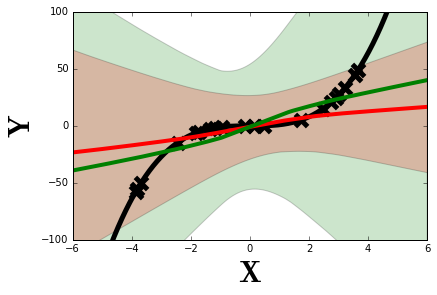

In [166]:
### Plotting ###    
plt.fill_between(x_true, pbbvi_pred_mean-2.*pbbvi_pred_std, pbbvi_pred_mean+2.*pbbvi_pred_std, facecolor='green', interpolate=True, alpha=.2)
plt.fill_between(x_true, elbo_pred_mean-2.*elbo_pred_std, elbo_pred_mean+2.*elbo_pred_std, facecolor='red', interpolate=True, alpha=.2)
plt.scatter(x, y, s=150, c='k', marker='x', linewidths=5)
plt.plot(x_true, y_true, '-k', linewidth=5.)
plt.plot(x_true, elbo_pred_mean, 'r-', linewidth=4.)
plt.plot(x_true, pbbvi_pred_mean, 'g-', linewidth=4.)

plt.xlim([-6, 6])
plt.ylim([-100, 100])
plt.ylabel(r"$\mathbf{Y}$", fontsize=30)
plt.xlabel(r"$\mathbf{X}$", fontsize=30)
plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=1.0)
plt.show()